In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

In [15]:
train_folder = 'data/train_/'
test_folder = 'data/test_/'
data_folder = 'data/'
random_subset = 10

In [16]:
files = !ls {train_folder}
files = np.array(files)
n = len(files)

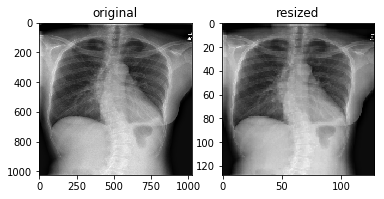

In [48]:
img = cv2.imread(f'{train_folder}{files[10]}',1)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('original')
img2 = cv2.resize(img,(128,128))
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('resized')

In [47]:
idx = np.random.choice(n,size=(random_subset,),replace=False)
for i, _ in enumerate(files[idx]):
    img = cv2.imread(f'{train_folder}{files[i]}',1)
    # all channels are same
    assert (np.logical_and( (img[:,:,0]==img[:,:,1]).all(), (img[:,:,1]==img[:,:,2]).all()) == True )

In [19]:
labels_tr = pd.read_csv(f'{data_folder}train.csv')
labels_tr.head()

,row_id,age,gender,view_position,image_name,detected
0,id_0,45,M,0,scan_0000.png,class_3
1,id_1,57,F,0,scan_0001.png,class_3
2,id_10,58,M,0,scan_00010.png,class_3
3,id_1000,64,M,0,scan_0001000.png,class_6
4,id_10000,33,M,1,scan_00010000.png,class_3


In [24]:
labels_tr.isnull().values.any() #no null values

False

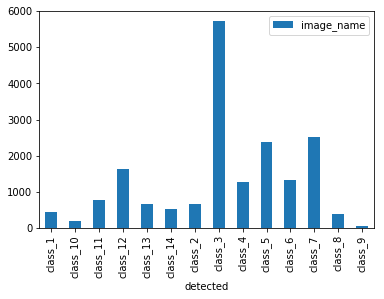

In [38]:
classes = pd.Series(['class_1','class_2', 'class_3', 'class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13','class_14',])
labels_tr.groupby('detected').count().reset_index().plot(kind='bar', x='detected',y='image_name')